Imports

In [ ]:
import numpy as np
import cvxpy as cp

## Exercise 1 - Investment Returns

Two investments are made, with random returns $R_1$ and $R_2$. The total return for the two investments is $R_1 + R_2$, and the probability of a loss (including breaking even, i.e., $R_1+R_2=0$) is $p^{loss} = \textbf{prob}(R_1 + R_2 \le 0)$. The goal is to find the worst-case (i.e., maximum possible) value of $p^{loss}$ consistent with the following information.

We discretize the values that $R_1$ and $R_2$ can take to $n=100$ possible values $r_1$, ..., $r_n$, uniformly spaced from $r_1 = -35$ to $r_n = +75$. $R_1$ and $R_2$ are assumed to have Gaussian [marginal distributions](https://en.wikipedia.org/wiki/Marginal_distribution) with known means $\mu_1$ and $\mu_2$ and known standard deviations $\sigma_1$ and $\sigma_2$. Hence, the discretized marginals $p^{(1)}$ and $p^{(2)}$ for $R_1$ and $R_2$ are given by

$$
\displaystyle p_i^{(k)} = \textbf{prob}(R_k = r_i) = \frac{\displaystyle e^{ \frac{-(r_i - \mu_k)^2}{2\sigma_k^2}}}{\displaystyle \sum_{j=1}^n e^{ \frac{-(r_j - \mu_k)^2}{2\sigma_k^2}}}
$$

for $k = 1,2$ and $i = 1, ..., n$. In addition it is known that $R_1$ and $R_2$ are correlated with [correlation coefficient](https://en.wikipedia.org/wiki/Correlation#Pearson's_product-moment_coefficient) $\rho$, which means that

$$
\sum_{i,j} (r_i - \mu_1) \cdot \textbf{prob}(R_1 = r_i , R_2 = r_j) \cdot (r_j - \mu_2) = \rho \sigma_1 \sigma_2
$$


Consider the data $\mu_1 =9$, $\mu_2 = 22$, $\sigma_1 = 7$, $\sigma_2 = 19$ and $\rho = -0.35$. 



In [ ]:
import cvxpy as cp
import numpy as np

# Data
n = 100
rmin = -35 
rmax = 75

mu1 = 9 
mu2 = 22
sigma1 = 7 
sigma2 = 19
rho = -0.35

Formulate the problem as a convex optimisation problem and solve it.

## Solution 1


In [ ]:
# Maximum ploss corresponds to minimum pwin(R1 + R2 > 0)
#Generate likelihood matrices for R1 and R2

x = np.linspace(rmin,rmax,n)
p1 = np.exp(-((x-mu1)**2)/(2*sigma1**2))
p2 = np.exp(-((x-mu2)**2)/(2*sigma2**2))

p1 = p1/p1.sum()
p2 = p2/p2.sum()

# This is our R1 + R2 matrix 
X = np.zeros((n,n))
for i in range(n):
  for k in range(n):
    X[i][k] = x[i] +x[k]



In [ ]:
# constraint is  = 
b = np.nonzero(X<=0) # index of nonzero elements 

P = cp.Variable((n,n))

objective = cp.Maximize(cp.sum(P[b]))

constraints = [(x-mu1) @ P @(x-mu2) == sigma1*sigma2*rho
               ,cp.sum(P) == 1
               ,P >= 0
              ,cp.sum(P,1) == p1
               ,cp.sum(P,0) == p2

               ]

# every p is bigger than zero

prob = cp.Problem(objective,constraints)



In [ ]:
prob.solve(verbose=True)

                                     CVXPY                                     
                                     v1.2.3                                    
(CVXPY) Jan 27 12:08:45 PM: Your problem has 10000 variables, 5 constraints, and 0 parameters.
(CVXPY) Jan 27 12:08:45 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 27 12:08:45 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 27 12:08:45 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 27 12:08:45 PM: Compiling problem (target solver=ECOS).
(CVXPY) Jan 27 12:08:45 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> C

0.18928791828101693

In [ ]:
(x-mu1).shape

(100,)

----------------------

## Exercise - Portfolio Optimization

The classical Markowitz portfolio optimisation problem is
naturally expressed as a bi-criterion minimisation problem, where the objectives are the negative mean return (since we wish to maximize mean return) and the variance of the return

$$
\begin{array}{ll}
\min & (-\bar{p}^\top x,x^\top \Sigma x )\\
s.t. & \mathbf{1}^\top x =1, \\ &x\succeq 0.\end{array}
$$

where $\bar{p}$ is the price mean and $\Sigma$ is the covariance. The two constraints express that $x$ indicates the normalised fraction of investement put into each asset (so the components of $x$ must sum to $1$) and the fact that we do not allow negative investments, called *shorts*. We scalarize the problem using the parameter $\lambda$

$$
\begin{array}{ll}
\min & -\bar{p}^\top x + \lambda x^\top \Sigma x \\
s.t. & \mathbf{1}^\top x =1, \\ &x\succeq 0\end{array}
$$

The parameter $\lambda>0$ is called *risk aversion parameter*. The objective $-\bar{p}^\top x + \lambda x^\top \Sigma x$ is called *risk-adjusted return*.

Consider a simple portfolio optimization problem with
$4$ assets, with price mean and covariance given in the code below.

In [ ]:
import numpy as np
import cvxpy as cp
n = 4
bar_p = np.array([0.12,0.1,0.07,0.03])
Sigma = np.zeros((n,n))
Sigma[0,0]=0.2*0.2
Sigma[1,1]=0.1*0.1
Sigma[2,2]=0.05*0.05
Sigma[3,3]=0

Note that asset $4$ is risk-free with certain $3\%$ return. The other assets have incresing return, ranging from $7\%$ to $12\%$, as well as increasing risk, ranging from $5\%$ to $20\%$.

1.    Construct the Pareto optimal curve for $\lambda \in [0.01,1000]$ (use a logarithmic spacing with $100$ points). The plot should have $\bar{p}^\top x_{opt}$ (mean return) on the $y$ axis and $\sqrt{x_{opt}^\top \Sigma x_{opt}}$ (standard deviation) on the $x$ axis. 
2.    Explain the meaning of the left-most point of the Pareto optimal curve.
3.    Explain the meaning of the right-most point of the Pareto optimal curve.
4.    For each of the following points ($+/- 0.001$) in the plot, establish and explain whether they are optimal, non-optimal or infeasible: 
    *    Standard deviation: $0.1$, Mean return: $0.108$
    *    Standard deviation: $0.05$, Mean return: $0.12$
    *    Standard deviation: $0.12$, Mean return: $0.05$

## Solution

In [ ]:
lambdas =  np.logspace(-2, 3, num=100, base=10)

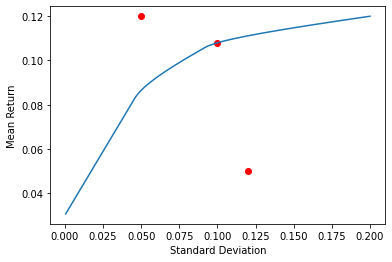

In [ ]:
results = []
stds = []

for i in range(100):
  l = lambdas[i]
  x = cp.Variable(n)
  #obj = cp.Minimize((-(bar_p.T@x) + l* (x.T@Sigma@x)) )
  obj = cp.Minimize(-bar_p @ x + l * cp.quad_form(x, Sigma))

  constraints = [ x >= 0,
                cp.sum(x) == 1]

  prob = cp.Problem(obj, constraints)

  prob.solve(verbose=False)

  #results.append(-prob.value)
  results.append(bar_p @ x.value)
  stds.append(np.sqrt(x.value.T @ Sigma @ x.value))

import matplotlib.pyplot as plt
plt.plot(stds, results)
plt.xlabel('Standard Deviation')
plt.ylabel('Mean Return')

# points in q4
new_stds = [0.1,0.05,0.12]
new_returns = [0.108,0.12,0.05]
plt.scatter(new_stds,new_returns,c='r')

plt.show()



2- The maximum return we can get for taking no risk i.e. when we have very high risk aversion (highest lambda)


3- The maximum return we can get for taking the highest amount of risk, i.e. when we have very low risk aversion ( lowest lambda)


4-
Standard deviation: 0.1, Mean return: 0.108
- This point is pareto optimal because we can not increase our return without increasing our risk

Standard deviation: 0.05, Mean return: 0.12
- This point is not pareto optimal because it is not feasible

Standard deviation: 0.12, Mean return:  0.05
- This point is not pareto optimal because for the same risk we can get a higher return by moving vertically up the plot, and we can get a lower risk for the same return by moving horizontally left to the pareto curve


In [ ]:
l = 0.01
x = cp.Variable(n)
#obj = cp.Minimize((-(bar_p.T@x) + l* (x.T@Sigma@x)) )
obj = cp.Minimize(-bar_p @ x + l * cp.quad_form(x, Sigma))

constraints = [ x >= 0,
              cp.sum(x) == 1]

prob = cp.Problem(obj, constraints)

prob.solve(verbose=False)

#results.append(-prob.value)
print(bar_p @ x.value)
print(np.sqrt(x.value.T @ Sigma @ x.value))

0.12
0.2


## Exercise 2 - Risk Free Option Pricing

In this problem we use the methods and results of Example 5.10 of $[1]$ to give bounds on the arbitrage-free price of an option (see also Exercise 5.38 of $[1]$ for more details). We will use all the notation and definitions from Example 5.10 of $[1]$.

We consider here options on an underlying asset (such as a stock); these have a payoff or value that depends on $S$, the value of the underlying asset at the end of the investment period. We will assume that the underying asset can only take on $m$ different values, $S^{(1)}$, ... $S^{(m)}$. These correspond to the $m$ possible scenarios or outcomes described in Example 5.10.



A risk-free asset has value $r>1$ in every scenario.

A *put option* at *strike price* $K$ gives the owner the right to sell one unit of the underlying stock at price $K$. At the end of the investment period, if the stock is trading at a price $S$, then the put option has payoff $(K-S)_+ = \max\{K-S,0\}$ (since the option is exercised only if $K>S$). Similarly a *call option* at strike price $K$ gives the buyer the right to buy a unit of stock at price $K$. A call option has payoff $(S-K)_+ = \max\{S-K,0\}$.

A collar is an option with payoff
$$
\left\{\begin{array}{ll}C-S_0, & S>0\\ S-S_0, & F \le S \le C\\F-S_0, & S\le F\end{array}\right.
$$

where $F$ is the *floor*, $C$ is the *cap* and $S_0$ is the price of the underlying asset at the start of the investment period. This option limits both the upside and downside of payoff.



Now we consider a specific problem. The price of the risk-free asset, with $r=1.05$, is $1$. The price of the underlying asset is $S_0=1$. We will use $m=200$ scenarios, with $S^{(i)}$ uniformly spaced from $S^{(1)} = 0.5$ to $S^{(200)} = 2$. The following options are traded on an exchange, with prices listed below.

$$
\begin{array}{lll}
\text{Type} &	\text{Strike} &	\text{Price}\\
\text{Call} &	1.1 &	0.06\\
\text{Call} &	1.2 &	0.03\\
\text{Put} &	0.8 &	0.02\\
\text{Put} &	0.7 &	0.01\\
\end{array}
$$

A collar with floor $F=0.9$ and cap $C=1.15$ is not traded on an exchange. Find the range (lower bound and upper bound) of the prices for this collar, consistent with the absence of arbitrage and the prices given above.

In [ ]:
# We define the data of the problem
m=200
p1=1
S0=1
r=1.05
K1=1.1
K2=1.2
K3=0.8
K4=0.7
C=1.15
F=0.9

p3 = 0.06
p4 = 0.03
p5 = 0.02
p6 = 0.01

In [ ]:
# We compute the matrix V as defined in Exercise 5.10 and the given table
S=np.linspace(0.5, 2, num=m)
V=np.zeros((m,7))

for i in range(m):
  if S[i]>C:
    collar=C-S0
  elif S[i]<=F:
    collar=F-S0
  else:
    collar=S[i]-S0

  V[i]=np.array([r,S[i],max(0,S[i]-K1),max(0,S[i]-K2),max(0,K3-S[i]),max(0,K4-S[i]),collar])

In [ ]:
# We define the variables
y = cp.Variable(m)
p7 = cp.Variable()

In [ ]:
# We solve the problem for the lower bound
p = np.array([p1, S0, p3, p4, p5, p6, 0])
prob = cp.Problem(cp.Minimize(p7),[V.T@y == p+np.array([0,0,0,0,0,0,1])*p7,y>=0])
prob.solve()

# Print result.
print("The lower bound is",np.round(p7.value,4))

The lower bound is 0.0326


In [ ]:
# We solve the problem for the upper bound
prob = cp.Problem(cp.Maximize(p7),[V.T@y == p+np.array([0,0,0,0,0,0,1])*p7,y>=0])
prob.solve()

# Print result.
print("The upper bound is",np.round(p7.value,4))

The upper bound is 0.065
